# `rioxarray`

In this lesson we will introduce [`rioxarray`](https://corteva.github.io/rioxarray/stable/), a Python extension for `xarray` to manipulate `xarray.DataArray`s as rasters. 

The name `rioxarray` stands for *raster input/output + xarray*. 

## About the data
The raster files we will use today come from the [US National Agriculture Imagery Program (NAIP)](https://naip-usdaonline.hub.arcgis.com). 
NAIP images are are high-resolution aerial images with four spectral bands: red (R), green (G), blue (B) and near-infrared (NIR). 
The raster's we'll use today are from 2020.

The data used in this lesson was pre-processing from a complete NAIP scene to separate the RGB bands from the NIR band and reduce the spatial extent. 
The data was accessed through [Microsoft's Planetary Computer NAIP data repository](https://planetarycomputer.microsoft.com/dataset/naip#overview).

## Import a TIF file

Let's start by loading the libraries we will use: 

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr

There are [multiple ways of opening a TIF file using `xarray` or `rioxarray`](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html). 
Using the `rioxarray.open_rasterio()` function to open the TIF file is a simple way to import the raster file as an `xarray.DataArray` and make sure all our geospatial data gets loaded correctly:

In [3]:
# Import NIR TIF file
root = os.path.join('/',
                  'courses',
                  'EDS220',
                  'data',
                  'rioxarray_lesson_data')
root

'/courses/EDS220/data/rioxarray_lesson_data'

In [6]:
# Import NIR TIF file
fp = os.path.join(root,
                  'NAIP_SB_nir.tif')

nir = rioxr.open_rasterio(fp)

In [5]:
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)> Size: 8MB
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Directly access attributes of nir:

In [8]:
print('Shape: ', nir.shape)
print('Data type: ', nir.dtype)

Shape:  (1, 3208, 2419)
Data type:  uint8


`uint8` = one of the smallest number data types for Python = unsigned integers with 8 bits. It is used to represent numbers from 0 to 254

Using the `.values` attribute we can retrieve the underlying `numpy.array` holding the values of the variable:

In [9]:
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

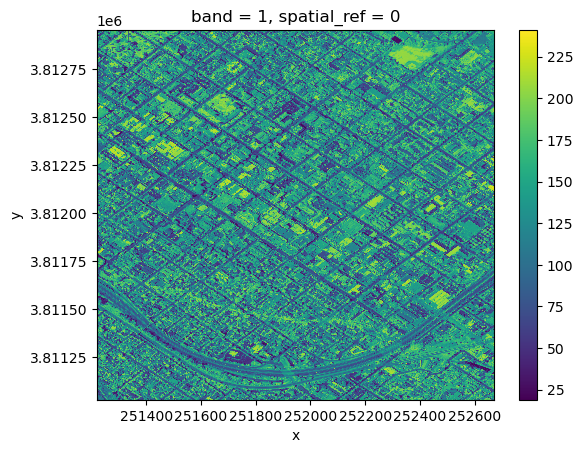

In [10]:
nir.plot()

## Drop a Dimension

Notice that our raster has an unnecessary extra dimension: band.

In [11]:
print("Sizes of dimensions:", dict(nir.sizes))

Sizes of dimensions: {'band': 1, 'y': 3208, 'x': 2419}


This is making this `xarray.DataArray` three-dimensional when it is not needed. We can “squeeze this dimension” of length 1 by:

1. using the `squeeze()` method. If we don’t pass any parameters, then `squeeze()` gets rid of all dimensions with length one, and then

2. getting rid of the associated coordinates for this dimension. We can do this using the `xarray.DataArray` `drop()` method and specifying the name of the coordinates we want to remove, in this case ‘band’.

Let’s do this:

In [12]:
# Original dimensions and coordinates
print(nir.dims, nir.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [13]:
# Remove length 1 dimension (band)
nir = nir.squeeze()
print(nir.dims, nir.coords, '\n')

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0 



In [14]:
# Remove coordinates associated to band
nir = nir.drop('band')
print(nir.dims, nir.coords)

('y', 'x') Coordinates:
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


/tmp/ipykernel_2112688/3604453383.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  nir = nir.drop('band')


## `rio` accessor

Remember an **accessor** in Python let’s us access a different set of properties of an object. We have previously used accesors like `.str` and `.dt` in `pandas` to work with strings and dates. In this lesson, we will use the `.rio` accessor for an `xarray.DataArray` to access its raster properties. For example, we can access the number of bands, height, width, spatial bounding box, and CRS:

In [16]:
# Examine raster attributes using rio accessor
print('Number of bands: ', nir.rio.count)
print('Height: ', nir.rio.height)
print('Width: ', nir.rio.width, '\n')

print('Spatial bounding box: ')
print(nir.rio.bounds(), '\n')

print('CRS: ', nir.rio.crs)

Number of bands:  1
Height:  3208
Width:  2419 

Spatial bounding box: 
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS:  EPSG:26911


## Multi-band raster

Let's now import the RGB raster:

In [18]:
# Import RGB raster
fp = os.path.join(root,'NAIP_SB_rgb.tif')
rgb = rioxr.open_rasterio(fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)> Size: 23MB
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Notice this raster has three bands, instead of one. This makes sense because we know these bands correspond to the red, green and blue bands of the image.

Finally, let’s plot this raster. Since it has three bands, we can plot it as an image using the `.plot.imshow()` method, which will interpret the three bands of the object as RGB.

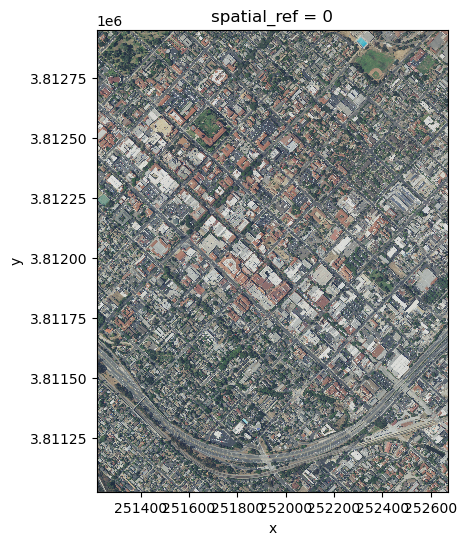

In [19]:
# Plot three bands as RGB image
rgb_aspect_ratio = rgb.rio.width / rgb.rio.height # Raster's aspect ratio
rgb.plot.imshow(size=6, # Plot's height in inches
                aspect=rgb_aspect_ratio # Ratio of width/height
               )

## Clip a raster

Our area of interest (AOI) for this lesson is a smaller region that includes only a few blocks around the NCEAS building. This is outlined in a GeoJSON file:

<Axes: >

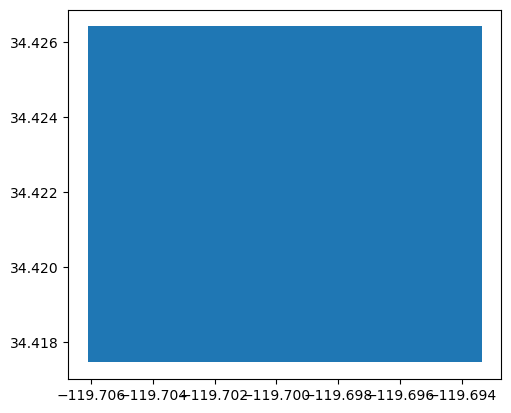

In [20]:
fp = os.path.join(root, 'SB_aoi.geojson')
aoi = gpd.read_file(fp)
aoi.plot()

Remember: **if two geospatial sets will interact they need to be in the same CRS**. In our case, the AOI `geopandas.GeoDataFrame` does not have the same CRS as the rasters:

In [21]:
# Examine CRS of all files
print('aoi CRS: ', aoi.crs)
print('nir CRS: ', nir.rio.crs)
print('rgb CRS: ', rgb.rio.crs)

aoi CRS:  EPSG:4326
nir CRS:  EPSG:26911
rgb CRS:  EPSG:26911


In [23]:
# Reproject AOI to RGB CRS
aoi = aoi.to_crs(rgb.rio.crs)
assert aoi.crs == rgb.rio.crs

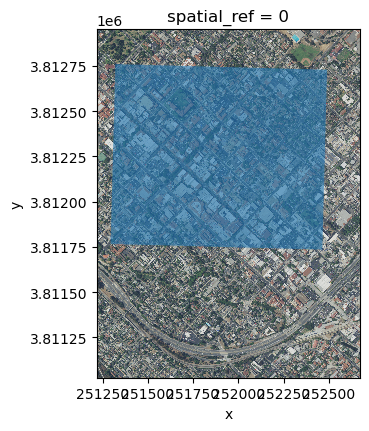

In [24]:
# Plot of RGB raster with AOI overlay
fig, ax = plt.subplots(figsize=(6, 6 * rgb_aspect_ratio)) # Directly set size
rgb.plot.imshow(ax=ax)
aoi.plot(ax=ax, alpha=0.6)
plt.show()

To clip the raster using the AOI polygon we use the `.rio.clip_box()` method:

In [25]:
# Clip raster to AOI
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

Original shape:  (3208, 2419)
Clipped shape:  (1710, 1995)


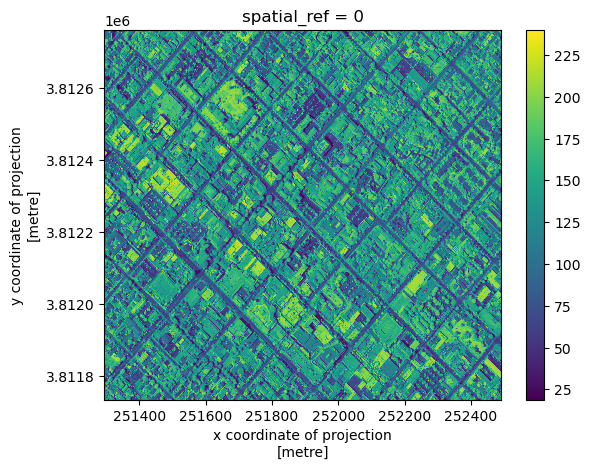

In [26]:
# Examine the clipped data
print('Original shape: ', nir.shape)
print('Clipped shape: ', nir_small.shape)
nir_small.plot()

Original shape:  (3208, 2419)
Clipped shape:  (3, 1710, 1995)


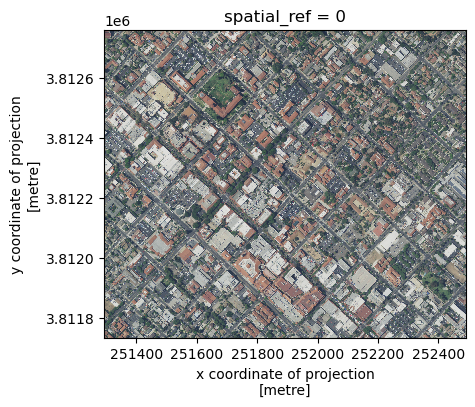

In [33]:
print('Original shape: ', nir.shape)
print('Clipped shape: ', rgb_small.shape)

# Plot with the correct size
ratio = rgb_small.rio.width / rgb_small.rio.height

rgb_small.plot.imshow(size=4,
                      aspect=ratio
                     )


## Raster algebra

In our case, we are interested in computing the Normalized Difference Vegetation Index (NDVI) over our AOI. The NDVI is an index commonly used to check if an area has live green vegetation or not.

- NDVI calculation ranges from -1 to 1
- negative values = water, impervious surfaces, rocks, snow, clouds
- bare soil = 0.1 - 0.2 range
- plants = always positive, between 0.2 and 1

Formula for NDVI is

$NDVI = \frac{NIR - RED}{NIR + RED}$

In [34]:
# Select the red band (by selecting dimension by name and coordinate by label)
red = rgb_small.sel(band=1)
red

<xarray.DataArray (y: 1710, x: 1995)> Size: 3MB
[3411450 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 16kB 2.513e+05 2.513e+05 ... 2.525e+05 2.525e+05
  * y            (y) float64 14kB 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

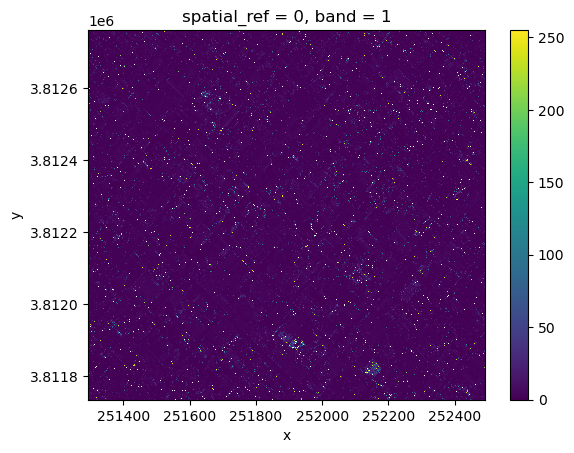

In [35]:
ndvi = (nir - red)/(nir + red)
ndvi.plot()

## Data type issues

The `uint8` (8-bit unsigned integer) is a very small data type that only holds integers from 0 up to 255. In particular, calculations don’t return what what we are used to when working with intgers.

In [37]:
np.uint8(150) + np.uint8(150)

/tmp/ipykernel_2112688/1890984988.py:1: RuntimeWarning: overflow encountered in scalar add
  np.uint8(150) + np.uint8(150)


44

In the NDVI formula we have to add NIR + Red. If both NIR and Red are very close to 255, when we add them, the calculation overflows the `uint8` data type and we don’t get the expected results.

## Updating data types

To be able to perform the calculation successfully, we will need to udpate the data type of our rasters into `int16`, which will be big enough to hold all the numbers that appear in the calculations:

In [38]:
# Update data type to int16 to perform NDVI calculations
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')

print(red16.dtype)
print(nir16.dtype)

int16
int16


In [39]:
# Calculate NDVI
ndvi = (nir16 - red16)/(nir16 + red16)

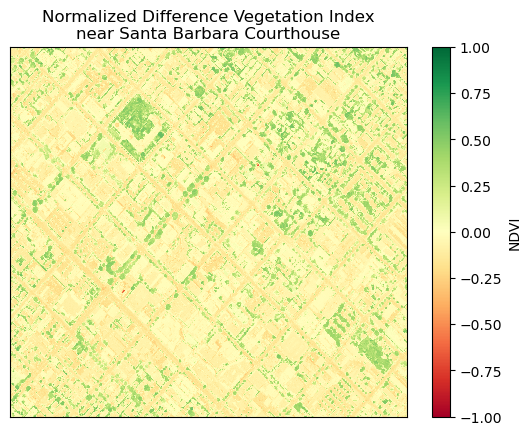

In [40]:
# Plot
fig, ax = plt.subplots()  # Adjust figure size
ndvi.plot(
    ax=ax,
    cmap="RdYlGn",  # Colormap for NDVI
    vmin=-1,  # Minimum value
    vmax=1,   # Maximum value
    cbar_kwargs={"label": "NDVI"}  # Label for color bar
)
ax.set_title("Normalized Difference Vegetation Index\nnear Santa Barbara Courthouse")  # Add title

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")  

plt.show()